# Setup the directories

In [1]:
import os
base_dir = '/home/ayan/Documents/Computer Vision/Classification/Cat_Vs_Dog/cats_and_dogs_images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Data Preprocessing using ImageDataGenerator
ImageDataGenerator converts image files into batches of preprocessed tensors
Note: A Python generator is an object that acts as an iterator

In [2]:
import tensorflow as tf

#Rescale all pixel values between 0 - 255 to (1, 0)
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_gen = train_idg.flow_from_directory(
    train_dir,
    target_size = (150, 150),       #resize images to (150, 150)
    batch_size = 32,                #20 samples per batch i.e. shape = (32, 150, 150, 3)
    class_mode = 'binary'           #since this is a binary classification problem
)

valid_gen = test_idg.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Build a small ConvNet model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

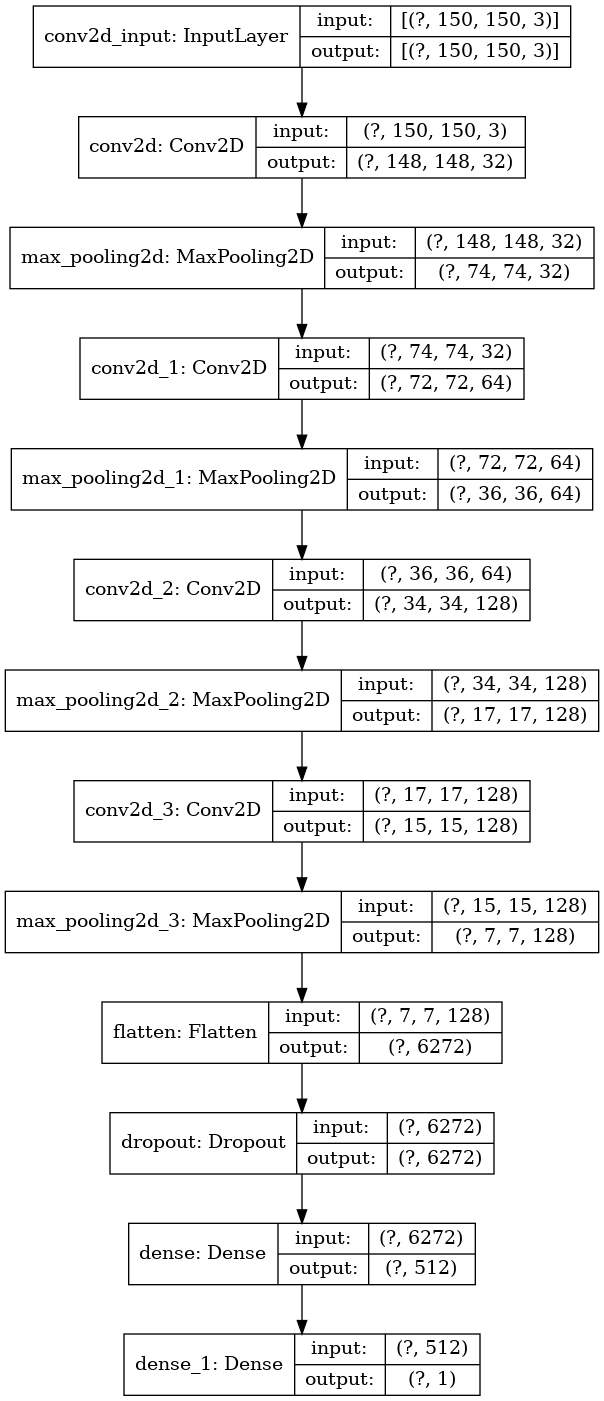

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',
                input_shape = (150, 150, 3))) #channel last; num of params = (32 * ((3 * 3 * 3) + 1)) = 896
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))


model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

tf.keras.utils.plot_model(model, show_shapes = True, to_file = 'simple_convnet.png')

# Keras Callback
Since I am running the training for a significant number of epochs hence it would be a good idea to implement callback to keep an eye on the training metrics

In [4]:
from keras import callbacks

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'binary_accuracy'
        , patience = 2
    ,),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'cat_vs_dog_1.h5'
        , monitor = 'val_loss'
        , save_best_only = True
    ,),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss'
        , factor = 0.1
        , patience = 5
        ,
    )
]

Using TensorFlow backend.


# Setup & configure optimizers
In this case RMSprop performs better than Adam.

In [5]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
             loss = tf.keras.losses.binary_crossentropy,
             metrics = [tf.keras.metrics.binary_accuracy])

# Use batch generator
'steps_per_epoch' is for telling the fit_generator that it needs to run mentioned number of gradient descent steps before drawing the next epoch batch
'validation_steps' tells the process about number of batches to draw from the validation generator

Note: With so little data it will be difficult to effectively mitigate overfitting. Will apply Data Augmentation technique in the next notebook

In [6]:
history = model.fit(
    train_gen,
    steps_per_epoch = 100,
    epochs = 100,
    callbacks = callbacks_list,
    validation_data = valid_gen,
    validation_steps = 50)

model.save('cat_vs_dog_1.h5')

Epoch 1/100
100/100 [==============================] - 4s 44ms/step - loss: 0.6854 - binary_accuracy: 0.5408 - val_loss: 0.6623 - val_binary_accuracy: 0.5933 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 4s 41ms/step - loss: 0.6505 - binary_accuracy: 0.6098 - val_loss: 0.6251 - val_binary_accuracy: 0.6411 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.5915 - binary_accuracy: 0.6847 - val_loss: 0.5972 - val_binary_accuracy: 0.6701 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 0.5625 - binary_accuracy: 0.7096 - val_loss: 0.6086 - val_binary_accuracy: 0.6714 - lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 4s 40ms/step - loss: 0.5332 - binary_accuracy: 0.7305 - val_loss: 0.5614 - val_binary_accuracy: 0.6948 - lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - 4s 41ms/step - loss: 0.5109 - binary_accuracy: 0.7487 - val_loss: 0.56

# Display training vs validation 

In [7]:
def smoothening(points, factor = 0.8):
    smooth_points = []
    for point in points:
        if smooth_points:
            previous = smooth_points[-1]
            smooth_points.append(previous * factor + point * (1 - factor))
        else:
            smooth_points.append(point)
    return smooth_points

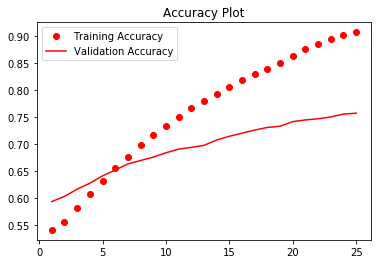

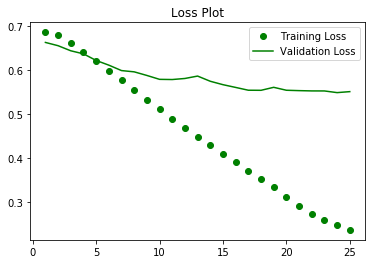

In [8]:
import matplotlib.pyplot as plt
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, smoothening(train_acc), 'ro', label = 'Training Accuracy')
plt.plot(epochs, smoothening(val_acc), 'r', label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.figure()
plt.plot(epochs, smoothening(train_loss), 'go', label = 'Training Loss')
plt.plot(epochs, smoothening(val_loss), 'g', label = 'Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()